<a href="https://colab.research.google.com/github/deepikayunduri/FaceRecognition/blob/main/Deepika_Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import numpy as np
import cv2
from random import shuffle
import pandas as pd
from PIL import Image
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path to the drive
data_path = '/content/drive/My Drive/datasets/real and fake face images.zip'

# storing the data in colab
extracted_path = '/content/real_and_fake_face_images'

# getting the data from the zip file
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)


# checking the files in the zip file
directory = '/content/real_and_fake_face_images'
print(os.listdir(directory))


['real_and_fake_face', 'real_and_fake_face_detection']


In [ ]:
# Accessing the "real_and_fake_face" folder and its subfolders
real_and_fake_face_folder = os.path.join(extracted_path, 'real_and_fake_face')
training_fake_folder = os.path.join(real_and_fake_face_folder, 'training_fake')
training_real_folder = os.path.join(real_and_fake_face_folder, 'training_real')

In [ ]:
# Accessing the image files
# fake images
fake_images = os.listdir(training_fake_folder)
# real iamges
real_images = os.listdir(training_real_folder)

## **Data Understanding**

In [ ]:

# Count the number of real and fake images
num_real_images = len(os.listdir(training_real_folder))
num_fake_images = len(os.listdir(training_fake_folder))

# Calculate the total number of images in the dataset
total_images = num_real_images + num_fake_images

# Class distribution (percentage)
percentage_real_images = (num_real_images / total_images) * 100
percentage_fake_images = (num_fake_images / total_images) * 100

# Print the dataset overview
print("Dataset Overview:")
print(f"Total Images: {total_images}")
print(f"Number of Real Images: {num_real_images} ({percentage_real_images:.2f}%)")
print(f"Number of Fake Images: {num_fake_images} ({percentage_fake_images:.2f}%)")

Dataset Overview:
Total Images: 2041
Number of Real Images: 1081 (52.96%)
Number of Fake Images: 960 (47.04%)


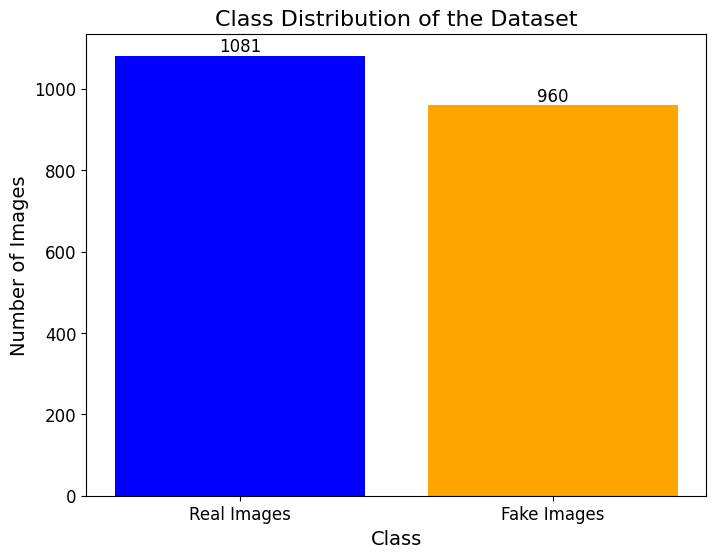

In [ ]:
# Data for the bar plot
class_labels = ['Real Images', 'Fake Images']
class_counts = [num_real_images, num_fake_images]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=['blue', 'orange'])
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Class Distribution of the Dataset', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding labels on the bars
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()


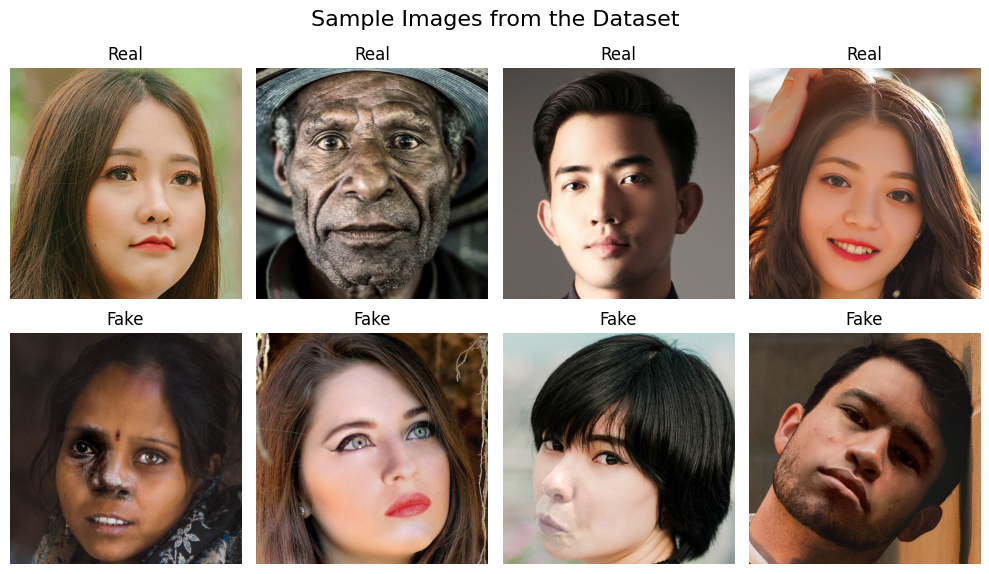

In [ ]:
# Function to display a few sample images from each class
def display_sample_images(images_folder, image_filenames, num_samples=4, random_seed=42):
    plt.figure(figsize=(10, 6))
    plt.suptitle("Sample Images from the Dataset", fontsize=16)

    # Randomly select a few samples from each class
    real_samples = random.sample(image_filenames['real'], num_samples)
    fake_samples = random.sample(image_filenames['fake'], num_samples)

    # Display real images
    for i in range(num_samples):
        plt.subplot(2, num_samples, i+1)
        img = mpimg.imread(os.path.join(images_folder, 'training_real', real_samples[i]))
        plt.imshow(img)
        plt.title("Real", fontsize=12)
        plt.axis('off')

    # Display fake images
    for i in range(num_samples):
        plt.subplot(2, num_samples, num_samples+i+1)
        img = mpimg.imread(os.path.join(images_folder, 'training_fake', fake_samples[i]))
        plt.imshow(img)
        plt.title("Fake", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Path to the folder containing the real and fake images
images_folder = '/content/real_and_fake_face_images/real_and_fake_face'

# Dictionary to store the filenames of real and fake images
image_filenames = {'real': real_images, 'fake': fake_images}

# Display a few sample images from the dataset
display_sample_images(images_folder, image_filenames)

## **Preprocessing**

In [ ]:
# Set the target image size for resizing
img_size = 128

# Function to load and resize an image
def load_and_resize_image(image_path):
    # Load an image using OpenCV, resize it to the specified size
    image = cv2.resize(cv2.imread(image_path), (img_size, img_size))
    return np.array(image)

# Function to create a dataset from image paths with labels
def create_dataset(image_paths, label):
    # Initialize empty lists to store images and their corresponding labels
    dataset = []
    labels = []

    # Loop through each image path in the list
    for path in tqdm(image_paths):
        # Load and resize the image using the function defined earlier
        image = load_and_resize_image(path)
        # Append the image and its label to the respective lists
        dataset.append(image)
        labels.append(label)

    # Return the dataset and labels as lists
    return dataset, labels

# Function to create the training data
def create_training_data(real_path, fake_path):
    # Create datasets for real and fake images using the create_dataset function
    real_images, _ = create_dataset(real_path[:981], label=1)
    fake_images, _ = create_dataset(fake_path[:860], label=0)

    # Concatenate real and fake images to create the training data
    X_train = real_images + fake_images
    # Create labels for the training data, with 1 for real and 0 for fake images
    Y_train = [1] * len(real_images) + [0] * len(fake_images)

    # Return the training data and labels
    return X_train, Y_train

# Function to create the test data
def create_test_data(real_path, fake_path):
    # Create datasets for real and fake images using the create_dataset function
    real_images, _ = create_dataset(real_path[981:], label=1)
    fake_images, _ = create_dataset(fake_path[860:], label=0)

    # Concatenate real and fake images to create the test data
    X_test = real_images + fake_images
    # Create labels for the test data, with 1 for real and 0 for fake images
    Y_test = [1] * len(real_images) + [0] * len(fake_images)

    # Return the test data and labels
    return X_test, Y_test

# Paths to the real and fake image folders
real = '/content/real_and_fake_face_images/real_and_fake_face/training_real'
fake = '/content/real_and_fake_face_images/real_and_fake_face/training_fake'

# List of real and fake image filenames
real_path = [os.path.join(real, img) for img in os.listdir(real)]
fake_path = [os.path.join(fake, img) for img in os.listdir(fake)]

# Create training and test datasets
X_train, Y_train = create_training_data(real_path, fake_path)
X_test, Y_test = create_test_data(real_path, fake_path)

100%|██████████| 100/100 [00:01<00:00, 86.37it/s]


In [ ]:
# Combine the images and labels for training data
train_data = list(zip(X_train, Y_train))
random.shuffle(train_data)  # Randomly shuffle the combined data
X_train, Y_train = zip(*train_data)  # Unzip the shuffled data back into X_train and Y_train

# Convert the combined and shuffled training data into a NumPy array
X_train = np.array(X_train)

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0

# Convert the labels for the training data into a NumPy array
Y_train = np.array(Y_train)

# Convert the combined test data into a NumPy array
X_test = np.array(X_test)

# Normalize pixel values to the range [0, 1]
X_test = X_test / 255.0

# Convert the labels for the test data into a NumPy array
Y_test = np.array(Y_test)

# Print the shape of the training data (excluding the number of samples)
print(X_train.shape[1:])

# Print the shape of the training data (including the number of samples)
print(X_train.shape[:])


(128, 128, 3)
(1841, 128, 128, 3)


In [ ]:
# Create a Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("relu"))

# Second Convolutional Layer
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("relu"))

# Third Convolutional Layer
model.add(Conv2D(16, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("relu"))

# Flatten the output for dense layers
model.add(Flatten())

# First Dense Layer
model.add(Dense(128, kernel_regularizer="l2"))
model.add(Activation("relu"))
model.add(Dropout(0.12))

# Second Dense Layer (Output Layer)
model.add(Dense(1))
model.add(Activation("sigmoid"))

# Define the optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0

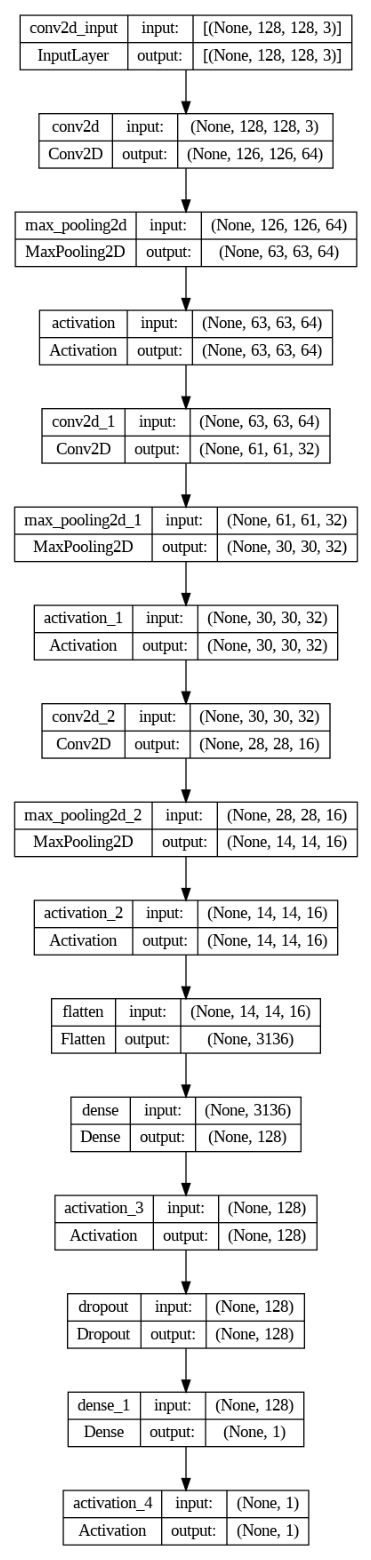

In [ ]:
# Visualize the model architecture and save the plot
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the saved plot
img = plt.imread('model_architecture.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#fitting the model with training and testing data
history=model.fit(X_train,Y_train, batch_size = 64, epochs = 9, validation_split = 0.2)

Epoch 1/9
23/23 [==============================] - 66s 3s/step - loss: 1.9596 - accuracy: 0.5401 - val_loss: 1.1073 - val_accuracy: 0.5149
Epoch 2/9
23/23 [==============================] - 68s 3s/step - loss: 0.8661 - accuracy: 0.5503 - val_loss: 0.7459 - val_accuracy: 0.5149
Epoch 3/9
23/23 [==============================] - 69s 3s/step - loss: 0.7040 - accuracy: 0.5788 - val_loss: 0.7505 - val_accuracy: 0.5122
Epoch 4/9
23/23 [==============================] - 62s 3s/step - loss: 0.6916 - accuracy: 0.6073 - val_loss: 0.6980 - val_accuracy: 0.5637
Epoch 5/9
23/23 [==============================] - 70s 3s/step - loss: 0.6843 - accuracy: 0.5999 - val_loss: 0.7033 - val_accuracy: 0.5528
Epoch 6/9
23/23 [==============================] - 67s 3s/step - loss: 0.6694 - accuracy: 0.6277 - val_loss: 0.6983 - val_accuracy: 0.5691
Epoch 7/9
23/23 [==============================] - 65s 3s/step - loss: 0.6590 - accuracy: 0.6270 - val_loss: 0.7067 - val_accuracy: 0.5474
Epoch 8/9
23/23 [==========

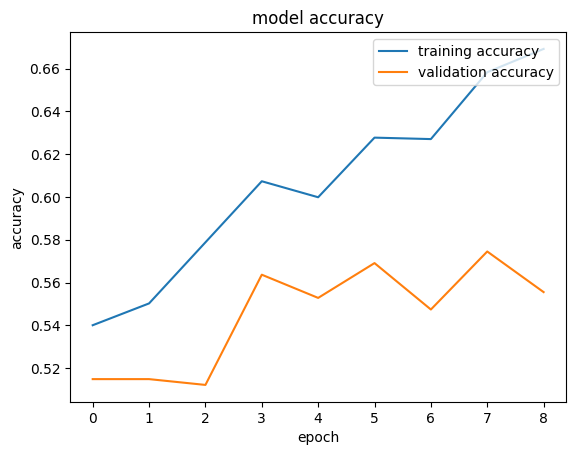

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper right')
plt.show()

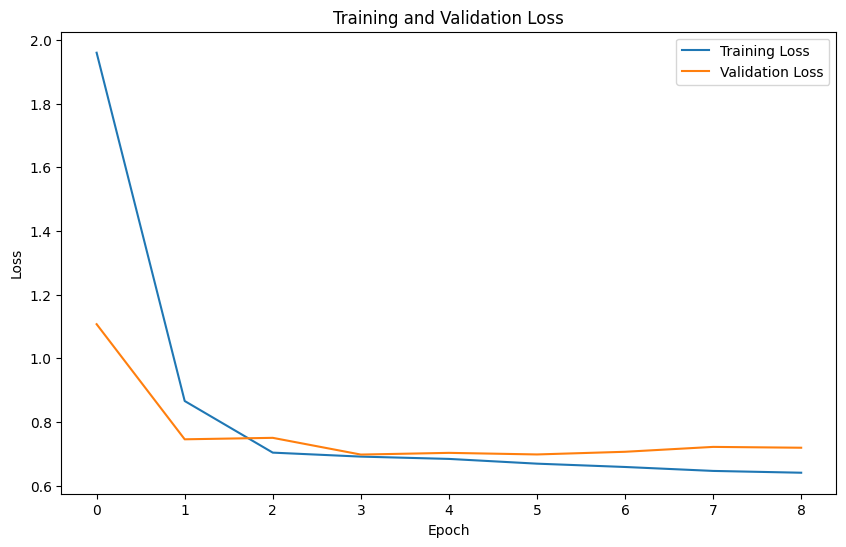

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy:", test_acc)

7/7 [==============================] - 2s 234ms/step - loss: 0.6963 - accuracy: 0.6150
Test accuracy: 0.6150000095367432


In [ ]:
# Predict on the test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(Y_test, y_pred_binary, average='binary')

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

7/7 [==============================] - 2s 249ms/step
Precision: 0.5877862595419847
Recall: 0.77
F1 Score: 0.6666666666666667


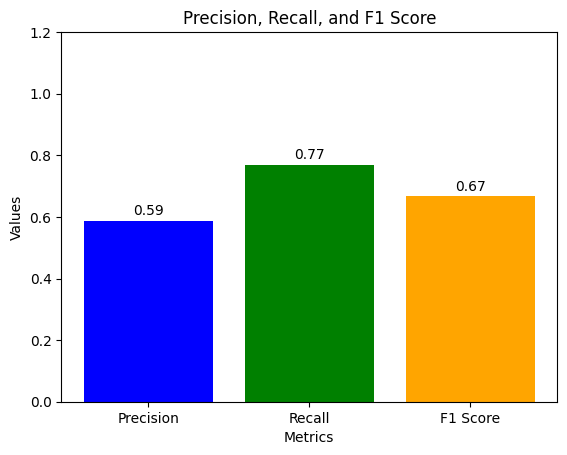

In [ ]:
# Create a bar graph
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

plt.bar(metrics, values, color=['blue', 'green', 'orange'])

# Add values on top of the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Precision, Recall, and F1 Score')
plt.ylim([0, 1.2])

# Show the plot
plt.show()

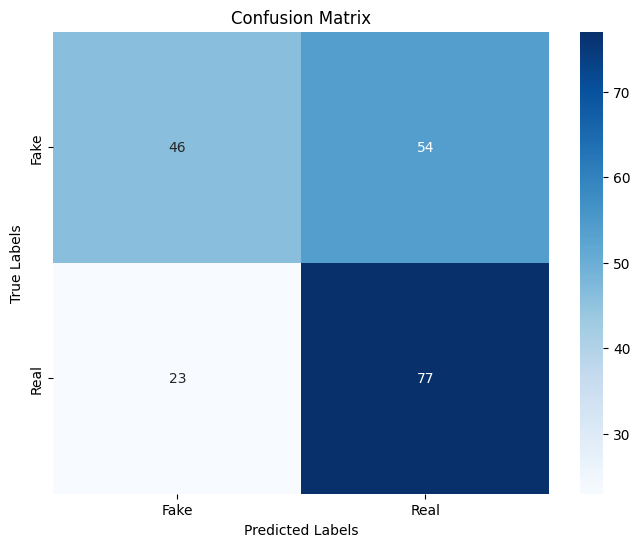

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
conf_matrix

array([[46, 54],
       [23, 77]])